In [ ]:
pip install tensorflow numpy opencv-python selenium rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 18.5 MB/s eta 0:00:00


In [ ]:
import folium
import time
import rasterio
import math
import os
import cv2
import shutil
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import tensorflow as tf
import ipywidgets as widgets

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.chrome.options import Options

from PIL import Image

from rasterio.features import rasterize
from rasterio.transform import from_bounds

from shapely.geometry import mapping

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from IPython.display import display, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class solar_panels():
  def __init__(self, place):
    len = 0.05
    lat_min = place[0] - len/2
    lon_min = place[1] - len/2
    lat_max = place[0] + len/2
    lon_max = place[1] + len/2

    # Define the bounding box coordinates
    bounds = [[lat_min, lon_min], [lat_max, lon_max]]

    # Calculate the center of the bounding box
    lat_center = (lat_min + lat_max) / 2
    lon_center = (lon_min + lon_max) / 2

    # Mapbox satellite tiles URL with your access token
    access_token = 'pk.eyJ1IjoiaXNzZW1zYXRvIiwiYSI6ImNtM2l5OG5xNzA2cnIya3NlN2Fodzd4NWwifQ.3g96NlYH2koRGchHZ1_yGw'
    tiles_url = f'https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token={access_token}'

    # Create a folium map centered on the calculated center point with Mapbox satellite tiles
    m = folium.Map(
        location=[lat_center, lon_center],
        zoom_start=30,
        tiles=tiles_url,
        attr='Mapbox',
    )

    # Set the map to fit within the bounding box
    m.fit_bounds(bounds)

    m.save("map.html")

    # Set up Selenium WebDriver with headless Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    # Open the HTML file and take a high-resolution screenshot
    driver = webdriver.Chrome(options=options)
    driver.set_window_size(4000, 4000)
    driver.get("file://" + "/content/map.html")

    time.sleep(3)

    driver.save_screenshot("high_res_satellite_region.png")
    driver.quit()

  def interactive_image_cropper(self, image_path, output_path="satellite.png"):
      """
      Initialize the image cropper with the input image and output path.

      Parameters:
          image_path (str): Path to the input image.
          output_path (str): Path to save the cropped image.
      """
      self.image_path = image_path
      self.output_path = output_path

      # Load the image
      self.img = Image.open(image_path)
      self.width_og, self.height_og = self.img.size
      self.width, self.height = self.img.size

      # Initial crop values
      self.crop_values = {"left": 0, "right": 0, "top": 0, "bottom": 0}

      # Output area for the image preview
      self.output = widgets.Output()

      # Create text boxes for adjustments
      self.textboxes = {
          key: widgets.IntText(value=0, description=f"{key.capitalize()}:")
          for key in self.crop_values
      }

      # Create buttons for confirmation
      self.save_button = widgets.Button(description="Save", button_style="success")
      self.retry_button = widgets.Button(description="Reset", button_style="warning")

      self._attach_handlers()

      # Display the UI
      self._create_ui()

  def _attach_handlers(self):
      """Attach handlers to text boxes and buttons."""
      for key, textbox in self.textboxes.items():
          textbox.observe(
              lambda change, k=key: self._update_crop_value(k, change["new"]),
              names="value"
          )
          textbox.observe(self.update_crop, names="value")

      self.save_button.on_click(self._on_save_click)
      self.retry_button.on_click(self._on_retry_click)

  def _update_crop_value(self, key, value):
      """Update the crop value for a specific direction."""
      self.crop_values[key] = value

  def update_crop(self, change=None):
      """Update the cropped image preview based on text box values."""
      with self.output:
          clear_output(wait=True)
          cropped_img = self.img.crop((
              self.crop_values["left"],
              self.crop_values["top"],
              self.width_og - self.crop_values["right"],
              self.height_og - self.crop_values["bottom"]
          ))
          self.width, self.height = cropped_img.size
          print(f"Current crop: Left={self.crop_values['left']}, Right={self.crop_values['right']}, "
                f"Top={self.crop_values['top']}, Bottom={self.crop_values['bottom']}")
          print(f"Image current size: Width={self.width}, Height={self.height}")
          plt.imshow(np.array(cropped_img))
          plt.axis("off")
          plt.show()

  def _on_save_click(self, b):
      """Save the cropped image."""
      cropped_img = self.img.crop((
          self.crop_values["left"],
          self.crop_values["top"],
          self.width_og - self.crop_values["right"],
          self.height_og - self.crop_values["bottom"]
      ))
      if ((self.width % 200) != 0) or ((self.height % 200) != 0):
        print('The image need to be divisible in segments of dimensions 200x200 pixels, please adjust your crop!')
      else:
        cropped_img.save(self.output_path)
        print(f"Image saved as {self.output_path}")

  def _on_retry_click(self, b):
      """Reset the text boxes and update the crop."""
      for key in self.crop_values:
          self.textboxes[key].value = 0
          self.width, self.height = self.img.size

  def _create_ui(self):
      """Create and display the UI for the cropper."""
      ui = widgets.VBox([
          widgets.HBox([self.textboxes["left"], self.textboxes["right"]]),
          widgets.HBox([self.textboxes["top"], self.textboxes["bottom"]]),
          widgets.HBox([self.save_button, self.retry_button]),
          self.output
      ])
      display(ui)
      self.update_crop()

  # IoU Metric
  def iou_metric(self, y_true, y_pred):
      """
      Computes the Intersection over Union (IoU) metric.
      """
      # Apply threshold to predictions
      y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)
      intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
      union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection

      # Smooth to avoid division by zero
      iou = K.mean((intersection + 1e-7) / (union + 1e-7), axis=0)
      return iou

  # Dice Loss Function
  def dice_loss(self, y_true, y_pred):
      """
      Computes the Dice loss for binary segmentation.
      """
      smooth = 1e-7
      intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
      union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
      dice = (2. * intersection + smooth) / (union + smooth)
      return 1 - dice


  def segment_image(self, image):
      """
      Segments an image by dividing it into non-overlapping patches,
      processing each patch, and reconstructing the segmented mask.
      :param image: Input image as a NumPy array (H x W x C).
      :return: Combined mask of the same size as the input image.
      """
      h, w, c = image.shape
      patch_size = self.patch_size

      # Ensure the image dimensions are divisible by patch_size
      assert h % patch_size == 0 and w % patch_size == 0, \
          f"Image dimensions must be divisible by patch size without padding. Current image size: {image.shape}"

      # Create an empty mask to store the predicted patches
      combined_mask = np.zeros((h, w), dtype=np.uint8)

      # Process the image in non-overlapping patches
      for y in range(0, h, patch_size):
          for x in range(0, w, patch_size):
              # Extract the patch
              patch = image[y:y + patch_size, x:x + patch_size]

              # Normalize to [0,1] and expand dimensions for the model
              patch_normalized = patch / 255.0
              patch_input = np.expand_dims(patch_normalized, axis=0)

              # Predict the mask for the patch
              predicted_mask = self.model.predict(patch_input)
              predicted_mask = (predicted_mask[0, :, :, 0] > 0.5).astype(np.uint8)

              # Place the predicted mask in the combined mask
              combined_mask[y:y + patch_size, x:x + patch_size] = predicted_mask * 255  # Scale back to [0, 255]

      return combined_mask

  def save_mask(self, mask, output_path):
      """
      Saves a mask as a PNG image.
      :param mask: Mask as a NumPy array.
      :param output_path: Path to save the mask.
      """
      cv2.imwrite(output_path, mask)

  def process_and_save(self, image_path="satellite.png", output_mask_path="output_mask.png", patch_size=200):
      """
      Reads an image, segments it, and saves the combined mask.
      :param image_path: Path to the input image.
      :param output_mask_path: Path to save the combined mask.
      """
      model_path = '/content/drive/MyDrive/ComputerVisionProject_Group_Due/model_epoch_10.keras'
      # Pass the custom loss function and custom metrics
      custom_objects = {"dice_loss": self.dice_loss,
                        "iou_metric": self.iou_metric
                        }
      self.model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
      self.patch_size = patch_size

      image = cv2.imread(image_path, cv2.IMREAD_COLOR)
      if image is None:
          raise FileNotFoundError(f"Image not found at {image_path}")

      # Segment the image
      combined_mask = self.segment_image(image)

      self.save_mask(combined_mask, output_mask_path)
      print(f"Mask saved to {output_mask_path}")

  def overlay_and_visualize(self, satellite_path="satellite.png", mask_path="output_mask.png"):
        """
        Overlay the mask on the satellite image for visualization.
        """
        satellite = Image.open(satellite_path)
        mask = Image.open(mask_path)

        # Convert images to arrays
        satellite_array = np.array(satellite)
        mask_array = np.array(mask)

        plt.figure(figsize=(10, 10))
        plt.imshow(satellite_array, alpha=0.8)
        plt.imshow(mask_array, cmap="Reds", alpha=0.5)
        plt.title("Overlay of Mask on Satellite Image")
        plt.axis("off")
        plt.show()

  def count_red_pixels(self, image_path="output_mask.png"):
      """
      Count the total number of red pixels in the segmented mask.

      Parameters:
          image_path (str): Path to the input mask image.

      Returns:
          int: Total number of red pixels.
      """

      image = cv2.imread(image_path)

      if image is None:
          raise ValueError("Image not found or cannot be read. Check the file path.")

      # Convert the image to RGB format
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Define a mask for red pixels
      red_mask = (image[:, :, 0] == 255) & (image[:, :, 1] == 255) & (image[:, :, 2] == 255)

      # Count the number of red pixels
      red_pixel_count = np.sum(red_mask)

      return red_pixel_count

  def solar_panel_amount(self, n_pixels):
      """
      Estimate the number of solar panels that can be placed based on red pixel count.

      Parameters:
          n_pixels (int): Total number of red pixels.

      Returns:
          float: Estimated number of solar panels.
      """

      # Convert Pixels to Area
      exchange = 6550 / (4000 ** 2)
      total_area_meters = n_pixels * exchange
      solar_panel_dimension = 1.65
      return total_area_meters / solar_panel_dimension

  def analyze_and_estimate_panels(self, mask_path="output_mask.png"):
      """
      Analyze the mask and estimate the number of solar panels.

      Parameters:
          mask_path (str): Path to the mask image.

      Returns:
          float: Estimated number of solar panels.
      """
      red_pixels = self.count_red_pixels(mask_path)
      total_panels = self.solar_panel_amount(red_pixels)
      print(f"Total number of red pixels: {red_pixels}")
      print(f"Estimated number of solar panels: {total_panels}")
      return total_panels


In [ ]:
place = [46.05061716859226, 14.507424257837954] # Ljubljana
solar = solar_panels(place)
solar.interactive_image_cropper("high_res_satellite_region.png")
# we suggest to crop:
# - 1500 from both right and left
# - 1404 from both up and down
# so that the picture is of a correct size

Image saved as satellite.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
Mask saved to output_mask.png


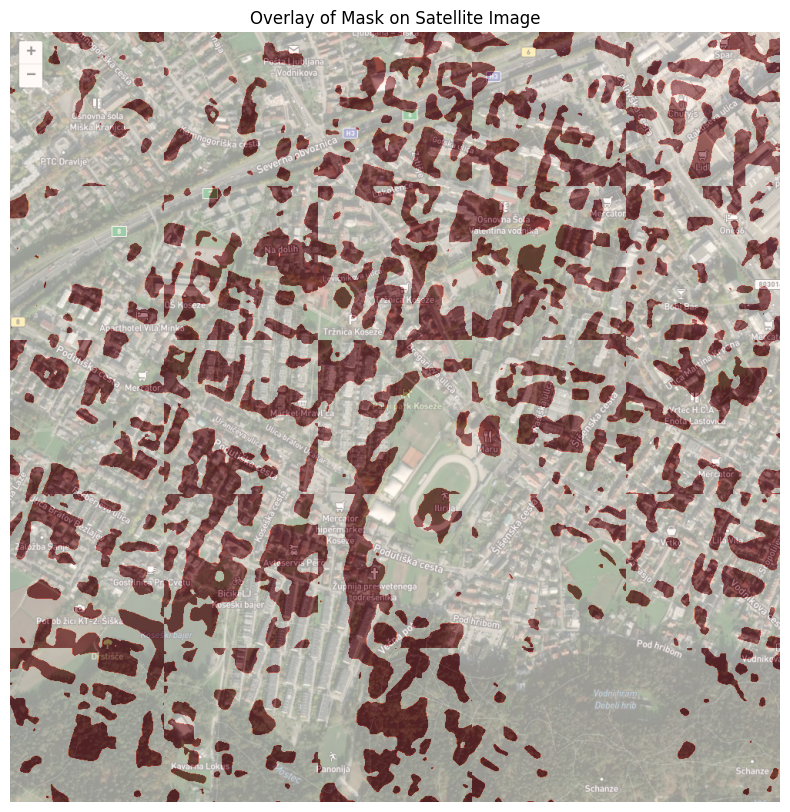

Total number of red pixels: 262639
Estimated number of solar panels: 65.16232765151516


In [ ]:
solar.process_and_save()
solar.overlay_and_visualize("high_res_satellite_region.png", "output_mask.png")
total_panels = solar.analyze_and_estimate_panels("output_mask.png")

In [ ]:
class calculate_energy_output():
    def __init__(self, lat, lon, n_panels, start_year, end_year):
        self.lat = lat
        self.lon = lon
        self.n_panels = n_panels
        self.start_year = start_year
        self.end_year = end_year

    def automate_pvgis_with_inputs(self):
        # Set up Selenium WebDriver
        # Configure options
        options = Options()
        options.add_argument("--headless")
        options.add_argument("--no-sandbox")
        options.add_argument("--disable-dev-shm-usage")
        # Set a custom download directory
        prefs = {"download.default_directory": "/content"}
        options.add_experimental_option("prefs", prefs)

        # Create the WebDriver (Selenium Manager automatically handles driver setup)
        driver = webdriver.Chrome(options=options)

        # Example usage
        driver.get("https://www.google.com")

        total_pv_power = self.n_panels*0.33

        try:
            # Open PVGIS interactive tools page
            driver.get("https://re.jrc.ec.europa.eu/pvg_tools/en/")
            wait = WebDriverWait(driver, 20)

            # Wait for the page to fully load
            wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

            # Input latitude and longitude
            lat_input = wait.until(EC.presence_of_element_located((By.XPATH, '//input[@placeholder="Eg. 45.815"]')))
            lon_input = driver.find_element(By.XPATH, '//input[@placeholder="Eg. 8.611"]')
            lat_input.clear()
            lon_input.clear()
            lat_input.send_keys(str(self.lat))
            lon_input.send_keys(str(self.lon))
            lon_input.send_keys(Keys.RETURN)

            time.sleep(3)

            try:
                button = driver.find_element(By.XPATH, '//a[@data-target="#HR, #HR_results, #HR_results1"]')  # HOURLY DATA tab
                button.click()
                print('Hourly data selected')
            except:
                return 'Problem in finding the Hourly data page'

            # Click GO! button
            button = driver.find_element(By.XPATH, '//button[@id="btninputLatLon"]')
            button.click()
            print('Button GO! selected')

            time.sleep(2)

            # Check the box for 'PV Power'
            button = driver.find_element(By.XPATH, '//input[@id="pvcalculation"]')
            button.click()
            print('PV Power box checked')

            time.sleep(2)

            # Check the box for 'Optimize Slope and Azimut'
            button = driver.find_element(By.XPATH, '//input[@id="hourlyoptimalangles"]')
            button.click()
            print('Optimize slope and azimut box checked')

            # Choose start and end year
            start_year_dropdown = driver.find_element(By.XPATH, '//select[@id="hstartyear"]')
            Select(start_year_dropdown).select_by_visible_text(self.start_year)
            print('correct year selected')
            end_year_dropdown = driver.find_element(By.XPATH, '//select[@id="hendyear"]')
            Select(end_year_dropdown).select_by_visible_text(self.end_year)
            print('correct year selected')

            # Enable the "PV Power" checkbox
            pv_power_input = driver.find_element(By.XPATH, '//input[@id="peakpower"]')
            pv_power_input.clear()
            pv_power_input.send_keys(total_pv_power)
            print(f"Set Peak Power to {total_pv_power} kWp.")

            time.sleep(2)

            # Click "json"
            visualize_button = driver.find_element(By.XPATH, '//span[contains(text(),"json")]')
            visualize_button.click()

            print("CSV download initiated. Check your default download folder.")
        finally:
            # Close the WebDriver
            time.sleep(5)
            driver.quit()

    def get_latest_downloaded_file(self):

        download_dir = '/content'
        while not os.listdir(download_dir):
            time.sleep(1)

        # Get all files in the directory
        files = os.listdir(download_dir)
        full_paths = [os.path.join(download_dir, file) for file in files]

        # Find the most recently modified file
        self.latest_file = max(full_paths, key=os.path.getctime)
        print(f"The latest downloaded file is: {self.latest_file}")

    def load_json_file(self, file_path):
        """
        Load the JSON file and extract general information.
        """
        with open(file_path, "r") as file:
            data = json.load(file)

        # General information about the experiment
        location = data["inputs"]["location"]
        mounting_system = data["inputs"]["mounting_system"]["fixed"]
        pv_module = data["inputs"]["pv_module"]

        return data, location, mounting_system, pv_module


    def summarize_data(self, data, start_time, end_time):
        """
        Summarize the data for a specific time period.
        """
        outputs = data["outputs"]["hourly"]

        P = []
        G_i = []
        H_sun = []
        T2m = []
        WS10m = []
        Int = []

        # Filter data based on time range
        for element in outputs:
            time = element["time"]
            if start_time <= time <= end_time:
                P.append(element.get("P", 0))
                G_i.append(element.get("G(i)", 0))
                H_sun.append(element.get("H_sun", 0))
                T2m.append(element.get("T2m", 0))
                WS10m.append(element.get("WS10m", 0))
                Int.append(element.get("Int", 0))

        # Create summaries
        summary_info = {
            "Total Power Output (P)": round(sum(P), 2),
            "Average Power Output (P)": round(sum(P) / len(P), 2) if P else 0,
            "Total Global Irradiance (G(i))": round(sum(G_i), 2),
            "Average Global Irradiance (G(i))": round(sum(G_i) / len(G_i), 2) if G_i else 0,
            "Average Temperature (T2m)": round(sum(T2m) / len(T2m), 2) if T2m else 0,
            "Max Wind Speed (WS10m)": round(max(WS10m), 2) if WS10m else 0,
            "Total Hours of Sunlight (H_sun)": round(sum(H_sun), 2)
        }

        return summary_info


    # Main interactive script
    def main(self, file_path):

        # Load the JSON file
        data, location, mounting_system, pv_module = self.load_json_file(file_path)

        # Display general information
        print("\nGeneral Information about the Experiment:")
        print("Location:")
        print(f"  Longitude: {location['longitude']}")
        print(f"  Latitude: {location['latitude']}")
        print(f"  Elevation: {location['elevation']}")
        print("\nMounting System:")
        print(f"  Slope: {mounting_system['slope']}")
        print(f"  Azimuth: {mounting_system['azimuth']}")
        print(f"  Type: {mounting_system['type']}")
        print("\nPV Module:")
        print(f"  Technology: {pv_module['technology']}")
        print(f"  Peak Power: {pv_module['peak_power']}")
        print(f"  System Loss: {pv_module['system_loss']}")

        # Ask user for the start and end times
        start_date = input("\nEnter the start date (YYYY/MM/DD): ")
        start_time = input("Enter the start time (HH): ")
        end_date = input("Enter the end date (YYYY/MM/DD): ")
        end_time = input("Enter the end time (HH): ")

        # Combine date and time inputs into the required format
        start_datetime = f"{''.join(start_date.split('/'))}:{start_time}10"
        end_datetime = f"{''.join(end_date.split('/'))}:{end_time}10"

        # Generate summary for the selected period
        print("\nGenerating summary...")
        summary_info = self.summarize_data(data, start_datetime, end_datetime)

        # Display the summary
        print("\nSummary for the Selected Time Period:")
        for key, value in summary_info.items():
            print(f"{key}: {value}")

    def start_summary(self):
        clear_output(wait=True)

        # Run the interactive script
        if __name__ == "__main__":
            self.main(self.latest_file)

In [ ]:
initialization = calculate_energy_output(lat=46.05601716859226, lon=14.507424257837954, n_panels=round(total_panels,0), start_year = '2023', end_year='2023')
initialization.automate_pvgis_with_inputs()
initialization.get_latest_downloaded_file()
initialization.start_summary()

# we suggest to keep an eye out for the text boxes as they may disappear after a couple of minutes


General Information about the Experiment:
Location:
  Longitude: 14.507
  Latitude: 46.056
  Elevation: 303.0

Mounting System:
  Slope: {'value': 37, 'optimal': True}
  Azimuth: {'value': 4, 'optimal': True}
  Type: free-standing

PV Module:
  Technology: c-Si
  Peak Power: 21.45
  System Loss: 14.0

Enter the start date (YYYY/MM/DD): 2023/11/25
Enter the start time (HH): 11
Enter the end date (YYYY/MM/DD): 2023/12/25
Enter the end time (HH): 11

Generating summary...

Summary for the Selected Time Period:
Total Power Output (P): 908158.02
Average Power Output (P): 1259.58
Total Global Irradiance (G(i)): 51933.91
Average Global Irradiance (G(i)): 72.03
Average Temperature (T2m): 2.75
Max Wind Speed (WS10m): 4.0
Total Hours of Sunlight (H_sun): 3553.05
